In [2]:
import os
import pandas as pd

base_path = r"C:\Users\sagni\Downloads\Noise Mapper"

files = [
    "stations.csv",
    "station_month.csv",
    "noise_level_data.csv",
    "location.csv"
]

for file_name in files:
    path = os.path.join(base_path, file_name)
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"\n📄 {file_name} - shape {df.shape}")
        print("Columns:", list(df.columns))
    else:
        print(f"⚠ Missing: {file_name}")



📄 stations.csv - shape (70, 5)
Columns: ['Station', 'Name', 'City', 'State', 'Type']

📄 station_month.csv - shape (5005, 7)
Columns: ['Station', 'Year', 'Month', 'Day', 'Night', 'DayLimit', 'NightLimit']

📄 noise_level_data.csv - shape (417000, 2)
Columns: ['noise level ', 'label']

📄 location.csv - shape (10, 5)
Columns: ['id', 'latitude', 'longitude', 'radius', 'latestTimestamp']


✅ Best Model Accuracy: 96.25% with 110 trees


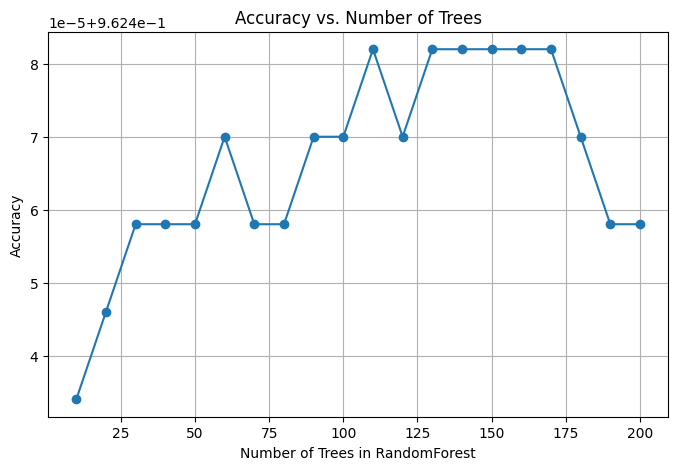

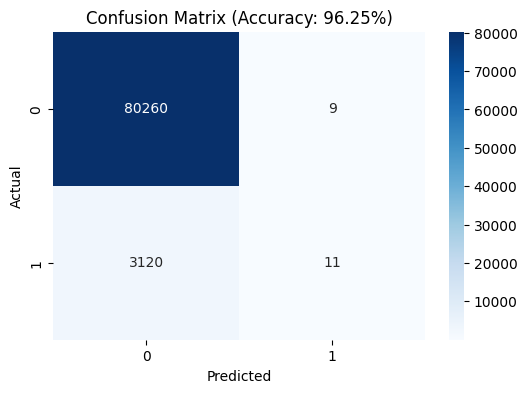

💾 Saved model as noise_model.pkl and datasets as HDF5.


In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# =========================
# 1. LOAD NOISE LEVEL DATA
# =========================
base_path = r"C:\Users\sagni\Downloads\Noise Mapper"
noise_df = pd.read_csv(os.path.join(base_path, "noise_level_data.csv"))

# Fix column names (remove extra spaces)
noise_df.columns = noise_df.columns.str.strip()

# Ensure numeric noise levels
noise_df["noise level"] = pd.to_numeric(noise_df["noise level"], errors="coerce")

# Drop missing rows
noise_df = noise_df.dropna(subset=["noise level", "label"])

# =========================
# 2. FEATURES & LABELS
# =========================
X = noise_df[["noise level"]]
y = noise_df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# 3. TRAIN MODEL & TRACK ACCURACY
# =========================
accuracies = []
n_estimators_list = range(10, 210, 10)  # from 10 to 200 trees

for n in n_estimators_list:
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Train final model with best estimator
best_n = n_estimators_list[np.argmax(accuracies)]
final_model = RandomForestClassifier(n_estimators=best_n, random_state=42)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
final_acc = accuracy_score(y_test, y_pred_final)

print(f"✅ Best Model Accuracy: {final_acc*100:.2f}% with {best_n} trees")

# =========================
# 4. ACCURACY GRAPH
# =========================
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, accuracies, marker="o")
plt.xlabel("Number of Trees in RandomForest")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Trees")
plt.grid(True)
plt.show()

# =========================
# 5. CONFUSION MATRIX HEATMAP
# =========================
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy: {final_acc*100:.2f}%)")
plt.show()

# =========================
# 6. SAVE MODEL & DATA
# =========================
# Save model as Pickle
with open(os.path.join(base_path, "noise_model.pkl"), "wb") as f:
    pickle.dump(final_model, f)

# Save features & labels as HDF5
X.to_hdf(os.path.join(base_path, "noise_features.h5"), key="features", mode="w")
y.to_hdf(os.path.join(base_path, "noise_labels.h5"), key="labels", mode="w")

print("💾 Saved model as noise_model.pkl and datasets as HDF5.")
